In [1]:
from keras.models import Sequential
from keras import layers
from keras.models import model_from_json
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

import numpy as np
import sys
import os


from keras import backend as K
K.clear_session()

#import keras
#keras.__version__
np.random.seed(42)

def preprocess():
    print("loading data...")
    with open("male.txt") as f:
        m_names = f.read().splitlines()
    
    with open("female.txt") as f:
        f_names = f.read().splitlines()
        
    bi_names = [] # unisex names 
    for f_name in f_names:
        if f_name in m_names:
            bi_names.append(f_name)
    
    m_names = [m_name.lower() for m_name in m_names if not m_name in bi_names]
    f_names = [f_name.lower() for f_name in f_names if not f_name in bi_names]
    

    # only male and only female names
    n_total = len(m_names) + len(f_names)
    
    max_len = max(len(max(m_names , key=len)), len(max(f_names , key=len)))
    
    chars = list(set("".join(m_names) + "".join(f_names)))
    chars.sort()

    n_chars = len(chars)
    
    char_indices = dict((c, i) for i, c in enumerate(chars))
    indices_char = dict((i, c) for i, c in enumerate(chars))
    
    print('Corpus...')
    print("total entries: " , n_total)
    print("max_len: " , max_len)
    print('total chars:', n_chars)
    
    X_m = name2vec(m_names, len(m_names), max_len, n_chars, char_indices)
    X_f = name2vec(f_names, len(f_names), max_len, n_chars, char_indices)
    
    y_m = np.ones((len(m_names) , 1))
    y_f = np.zeros((len(f_names) , 1))
    
    X = np.concatenate((X_m, X_f), axis=0)
    y = np.concatenate((y_m, y_f), axis=0)

    return X, y, max_len, n_chars, char_indices, chars


def name2vec(names, n_instances, max_len, n_chars, char_indices):
    X = np.zeros((n_instances, max_len, n_chars))
    for i, name in enumerate(names):
        for t, char in enumerate(name):
            X[i, t, char_indices[char]] = 1.0
    return X


def train_test_split(X, y, n_train=6000):
    n_total = X.shape[0]
    idx = np.random.permutation(n_total)
    
    X_train = X[idx][:n_train]
    y_train = y[idx][:n_train]
    
    X_test = X[idx][n_train:]
    y_test = y[idx][n_train:]

    return X_train, y_train, X_test, y_test


def build(max_len, n_chars):

    print('Build model...')
    model = Sequential()
    model.add(layers.LSTM(128, return_sequences=True, dropout=0.2, input_shape=(max_len, n_chars)))
    #model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(128, return_sequences=False, dropout=0.2))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model


'''
history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=128,
                    validation_split=0.2)
'''

'''
from matplotlib import pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
'''
def predict_gender(names, pred):
    print('Model predict...')
    p_male = 0
    p_female = 0
    for i in range(pred.shape[0]):
        if pred[i] > 0.5:
            p_male += 1
            print('%20s is Male'%names[i])
        else:
            p_female += 1
            print('%20s is Female'%names[i])
    print('predicted   male: ', p_male)
    print('predicted female: ', p_female)


Using TensorFlow backend.


In [2]:
X, y, max_len, n_chars, char_indices, chars = preprocess()

X_train, y_train, X_test, y_test = train_test_split(X, y)

filepath = 'gender_model_weights.h5'

model = build(max_len, n_chars)
   
if os.path.exists(filepath):
    model = load_model(filepath)
    print('successfully retriving model...')

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
n_epochs = 5
history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=64,
                    validation_split=0.2)

print('after training')
results = model.evaluate(X_test, y_test)
print('test :',results)

loading data...
Corpus...
total entries:  7214
max_len:  15
total chars: 29
Build model...
successfully retriving model...
Train on 4800 samples, validate on 1200 samples
Epoch 1/5
4800/4800 [==============================] - 7s 1ms/step - loss: 0.5605 - acc: 0.7102 - val_loss: 0.5081 - val_acc: 0.7558
Epoch 2/5
4800/4800 [==============================] - 6s 1ms/step - loss: 0.5179 - acc: 0.7415 - val_loss: 0.4788 - val_acc: 0.7742
Epoch 3/5
4800/4800 [==============================] - 6s 1ms/step - loss: 0.5171 - acc: 0.7394 - val_loss: 0.4825 - val_acc: 0.7858
Epoch 4/5
4800/4800 [==============================] - 6s 1ms/step - loss: 0.4984 - acc: 0.7544 - val_loss: 0.4631 - val_acc: 0.7758
Epoch 5/5
4800/4800 [==============================] - 6s 1ms/step - loss: 0.4900 - acc: 0.7669 - val_loss: 0.4538 - val_acc: 0.7875
after training
1214/1214 [==============================] - 0s 410us/step
test : [0.44297088621279357, 0.8072487646115474]


In [3]:
model.save(filepath)
del model

In [4]:
model = load_model(filepath)
print('successfully retriving model...')

successfully retriving model...


In [5]:
results = model.evaluate(X_test, y_test)
print('checking test :',results)

1214/1214 [==============================] - 1s 663us/step
checking test : [0.44297088621279357, 0.8072487646115474]


In [6]:
my_file_path = 'my_name2.txt'
with open(my_file_path) as f:
    origin_names = f.read().splitlines()
    input_names = [input_name.lower() for input_name in origin_names]

X_input = name2vec(input_names,  len(input_names), max_len, n_chars, char_indices)

pred = model.predict(X_input)
predict_gender(origin_names, pred)

Model predict...
              Adrian is Female
              Adrick is Male
              Adrien is Female
           Agamemnon is Male
           Aguinaldo is Male
              Aguste is Male
             Agustin is Female
              Aharon is Male
               Ahmad is Male
               Ahmed is Male
               Ahmet is Male
                Ajai is Female
                Ajay is Female
                  Al is Female
                Alaa is Female
               Alain is Female
                Alan is Female
            Alasdair is Female
            Alastair is Female
            Albatros is Male
              Albert is Male
             Alberto is Male
            Albrecht is Male
predicted   male:  12
predicted female:  11


In [8]:
pred_train = model.predict(X_train)
pred_label = [1.0 if p > 0.5 else 0.0 for p in pred_train]
print(len(pred_label))

6000


In [12]:
true_label = y_train

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_sonfusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    thresh = cm.max()/2.0
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment='center',color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')


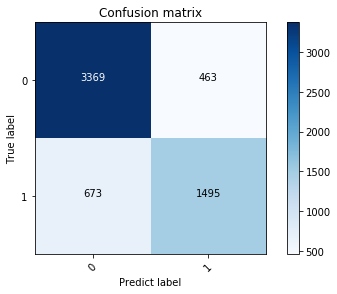

In [14]:
from sklearn.metrics import confusion_matrix
import itertools

confusion_mat = confusion_matrix(true_label, pred_label)
plot_sonfusion_matrix(confusion_mat, classes = range(2))